# Goal of Project 1

In this project, our goal is to predict the hourly bicyclists passing on Coupure Links in Ghent. First a thorough exploration of the dataset, encompassing descriptive statistics and visualizations to discern patterns, trends, and potential outliers, is performed. Feature selection and pre-processing follow, including handling missing values, encoding categorical variables, and considering temporal aspects. After pre-processing the data, a Histogram Gradient Boosting regressor model is used to predict the values of bicyclist passing by in July based on data of january-june.

On top of the primary forecasting goal, this project also acts as a first start to good machine learning practice including data exploration, validation of techniques used and an overall understanding of how to run a machine learning project from start to end.

Before anything, we load the libraries that are needed to run the code.

In [204]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import random
from datetime import date, timedelta
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# Data Exploration


### First dataset
We start the project by exploring the datasets that will be used to accomplish the goal. The first dataset contains hourly bike counts, spanning from January 1st to June 30th. These bike counts represent the 'Y' data, serving as the output that our model aims to predict. The second dataset is an array of weather data sourced from Open Meteo for the same timeline. This 'X' data forms the input for our model, allowing it to forecast the volume of cyclists traversing the area.

In [205]:
dfbikes = pd.read_csv('train_data.csv')
dfbikes.head()

,Date_hour,Totaal
0,2023-01-01T00,111.0
1,2023-01-01T01,201.0
2,2023-01-01T02,170.0
3,2023-01-01T03,144.0
4,2023-01-01T04,155.0


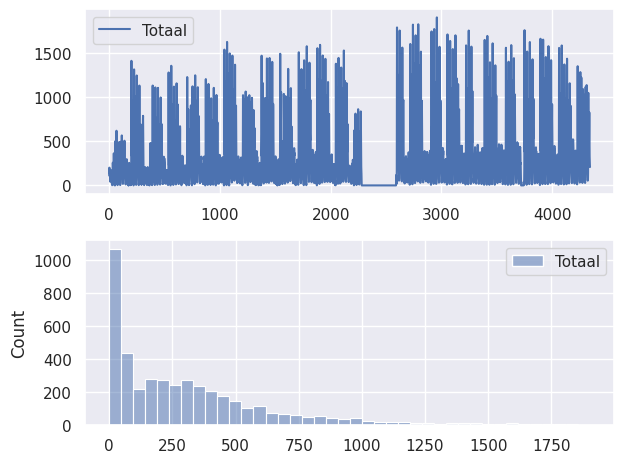

In [206]:
sns.set_theme()
fig, axes = plt.subplots(2, 1)
sns.lineplot(dfbikes, ax=axes[0])
sns.histplot(dfbikes, ax=axes[1])
plt.tight_layout()
plt.show()

In [207]:
counter_error = dfbikes.iloc[range(2279,2591)] # Returns true if all values are 0, otherwise returns False
print((counter_error['Totaal'] == 0).all())

True


We've identified a significant anomaly within our data, specifically from index 2279 (2023-04-06T00) to index 2591 (2023-04-18T23) in the first dataset. During this period, an unusual abundance of zero values appears, indicating a potential absence of data for these dates. This absence might be due to a counter error, making it challenging for our machine learning model to learn effectively from this timeframe. The same can be found on the data from 6th of June, where there are no bikes passing by for a full day. To prevent confusion within our model, we'll remove these entries.

Regrettably, a part of the removed timeframe coincides with the Easter break, a period with notably fewer students and cyclists in the city. This data void represents a valuable yet unusable segment for training our model. Utilizing this data would have been advantageous for predicting July's biking patterns, given the missing student presence in the city during that month.

Furthermore, the data exhibits a right-skewed distribution, evident in the histogram, closely resembling a Poisson distribution. This particular distributional aspect could introduce complexities in training a machine learning model  and needs to be taken into consideration. Despite the substantial removal of zero values, the data continues to exhibit a right-skewed pattern.

### Second dataset
Next in line is our exploration of the second dataset. This dataset, from Open Meteo, contains various weather-related variables such as Temperature (2 m), Dewpoint, Apparent Temperature, Precipitation (rain + snow), Surface Pressure, Cloudcover Total, Wind Speed (10m), Wind Direction (10m), Wind Gusts (10m), Is Day or Night, and Shortwave Solar Radiation. These variables are anticipated to have an impact, either positive or negative, on the volume of bicycle traffic. They consist of numerical variables, with the exception of 'Is Day or Night', which serves as a categorical variable. This particular variable holds a value of 0 during nighttime and darkness, while it equates to 1 during daytime and light.

In [208]:
dfwheater = pd.read_csv('Wheater train.csv', skiprows=3)
dfwheater['is_day ()'] = dfwheater['is_day ()'].astype('category')
dfwheater.head()

,time,temperature_2m (°C),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),winddirection_10m (°),windgusts_10m (km/h),is_day (),shortwave_radiation (W/m²)
0,2023-01-01T00:00,15.9,5.6,9.2,0.0,1006.2,44,38.7,218,66.6,0,0.0
1,2023-01-01T01:00,15.8,5.4,9.2,0.0,1006.7,78,37.3,220,65.2,0,0.0
2,2023-01-01T02:00,15.8,5.3,9.3,0.0,1006.7,86,36.9,218,68.0,0,0.0
3,2023-01-01T03:00,15.3,6.1,8.9,0.0,1006.4,80,37.0,217,67.7,0,0.0
4,2023-01-01T04:00,14.7,6.9,8.8,0.0,1007.3,70,35.5,220,64.1,0,0.0


The 'time' column has valuable information that can significantly contribute to our model's predictive capabilities. To harness this, we extract categorical variables such as the month, day of the week, and hour from this column, enlarging our dataset's features. Additionally, we incorporate a categorical feature indicating whether the specific date falls on a weekend or not, a factor that enhances the model's performance.

In [209]:
dfwheater['timestamp'] = pd.to_datetime(dfwheater['time'])
dfwheater['month'] = dfwheater['timestamp'].dt.month.astype("category")
dfwheater['day_of_week'] = dfwheater['timestamp'].dt.dayofweek.astype("category")
dfwheater['hour'] = dfwheater['timestamp'].dt.hour.astype("category")
dfwheater['is_weekend'] = dfwheater['day_of_week'].isin([5, 6]).astype(int).astype("category")
dfwheater.head()

,time,temperature_2m (°C),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),winddirection_10m (°),windgusts_10m (km/h),is_day (),shortwave_radiation (W/m²),timestamp,month,day_of_week,hour,is_weekend
0,2023-01-01T00:00,15.9,5.6,9.2,0.0,1006.2,44,38.7,218,66.6,0,0.0,2023-01-01 00:00:00,1,6,0,1
1,2023-01-01T01:00,15.8,5.4,9.2,0.0,1006.7,78,37.3,220,65.2,0,0.0,2023-01-01 01:00:00,1,6,1,1
2,2023-01-01T02:00,15.8,5.3,9.3,0.0,1006.7,86,36.9,218,68.0,0,0.0,2023-01-01 02:00:00,1,6,2,1
3,2023-01-01T03:00,15.3,6.1,8.9,0.0,1006.4,80,37.0,217,67.7,0,0.0,2023-01-01 03:00:00,1,6,3,1
4,2023-01-01T04:00,14.7,6.9,8.8,0.0,1007.3,70,35.5,220,64.1,0,0.0,2023-01-01 04:00:00,1,6,4,1


To augment the number of categorical variables, which demonstrated a positive impact on the model's outcomes through trial and error, we will introduce distinctions for public holidays and ugent holidays within the dataset. These holidays play a significant role in the forecast for July, given the abundance of such occasions during that month.

In [210]:
ugent_holidays = [
    date(2023, 1, 1),    # Sunday 01/01/2023 (Christmas recess)
    date(2023, 1, 2),    # Sunday 01/01/2023 (Christmas recess)
    date(2023, 1, 3),    # Sunday 01/01/2023 (Christmas recess)
    date(2023, 1, 4),    # Sunday 01/01/2023 (Christmas recess)
    date(2023, 1, 5),    # Sunday 01/01/2023 (Christmas recess)
    date(2023, 1, 6),    # Sunday 01/01/2023 (Christmas recess)
    date(2023, 1, 7),    # Sunday 01/01/2023 (Christmas recess)
    date(2023, 2, 6),    # Monday 06/02/2023 (Inter-term recess)
    date(2023, 2, 7),    # Tuesday 07/02/2023 (Inter-term recess)
    date(2023, 2, 8),    # Wednesday 08/02/2023 (Inter-term recess)
    date(2023, 2, 9),    # Thursday 09/02/2023 (Inter-term recess)
    date(2023, 2, 10),   # Friday 10/02/2023 (Inter-term recess)
    date(2023, 2, 11),   # Saturday 11/02/2023 (Inter-term recess)
    date(2023, 3, 24),   # Friday 24 March 2023 (Dies Natalis)
    date(2023, 4, 3),    # Monday 3 April 2023 (Eastern recess)
    date(2023, 4, 4),    # Tuesday 4 april 2023 (Eastern recess)
    date(2023, 4, 5),    # Wednesday 5 april 2023 (Eastern recess)
    date(2023, 5, 1),    # Monday 1 May 2023 (Labour Day)
    date(2023, 5, 18),   # Thursday 18 May 2023 (Ascension)
    date(2023, 5, 19),   # Friday 19 May 2023 (Ascension)
    date(2023, 5, 22),   # Monday 22/05/2023 (catch-up activities)
    date(2023, 5, 23),   # Tuesday 23/05/2023 (catch-up activities)
    date(2023, 5, 24),   # Wednesday 24/05/2023 (catch-up activities)
    date(2023, 5, 25),   # Thursday 25/05/2023 (catch-up activities)
    date(2023, 5, 26),   # Friday 26/05/2023 (catch-up activities)
    date(2023, 5, 27),   # Saturday 27/05/2023 (catch-up activities)
    date(2023, 5, 28),   # Sunday 28/05/2023 (catch-up activities)
    date(2023, 5, 29),   # Monday 29 May 2023 (Whit Monday)
]
july_dates = []
start_date = date(2023, 7, 1)
end_date = date(2023, 7, 31)
current_date = start_date
while current_date <= end_date:
    july_dates.append(current_date)
    current_date += timedelta(days=1)
ugent_holidays += july_dates
dfwheater['ugent_holiday'] = dfwheater['timestamp'].apply(lambda x: 1 if x.date() in ugent_holidays else 0).astype("category")

holiday = list(holidays.CountryHoliday('BE', years=2023).keys()) # Contains all belgian holidays in the year 2023
dfwheater['is_holiday'] = dfwheater['timestamp'].apply(lambda x: 1 if x.date() in holiday else 0).astype("category")
all_holidays = ugent_holidays + holiday

#### Checking correlations in the numerical input variables
Reviewing variable correlations in the input dataset, particularly when utilizing a machine learning model like RandomForestRegressor, is importan. This examination helps uncover redundant or highly interdependent features. Such features may negatively impact the model's efficiency and predictive accuracy, thus warranting their elimination. By discarding correlated variables, the risk of multicollinearity is mitigated, which could otherwise result in unstable and less reliable model outcomes.

<ipython-input-211-f791623fd16d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dfwheater.corr()


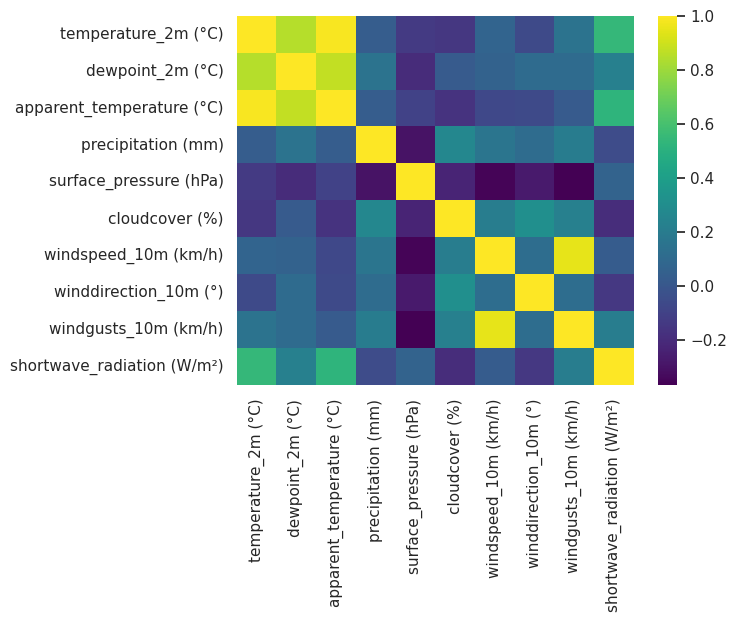

In [211]:
corr = dfwheater.corr()
sns.set_theme()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap='viridis')
plt.show()

In [212]:
corr

,temperature_2m (°C),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),winddirection_10m (°),windgusts_10m (km/h),shortwave_radiation (W/m²)
temperature_2m (°C),1.000000,0.847617,0.987191,0.031855,-0.138270,-0.151516,0.065533,-0.061528,0.153313,0.541174
dewpoint_2m (°C),0.847617,1.000000,0.872409,0.152587,-0.201141,0.021706,0.054138,0.105589,0.102856,0.221061
apparent_temperature (°C),0.987191,0.872409,1.000000,0.028293,-0.097805,-0.166034,-0.073900,-0.058989,0.019583,0.519004
precipitation (mm),0.031855,0.152587,0.028293,1.000000,-0.303582,0.266504,0.164929,0.109353,0.199926,-0.056632
surface_pressure (hPa),-0.138270,-0.201141,-0.097805,-0.303582,1.000000,-0.234792,-0.356888,-0.272763,-0.368536,0.061921
cloudcover (%),-0.151516,0.021706,-0.166034,0.266504,-0.234792,1.000000,0.205057,0.309548,0.223264,-0.196731
windspeed_10m (km/h),0.065533,0.054138,-0.073900,0.164929,-0.356888,0.205057,1.000000,0.114192,0.948290,0.021826
winddirection_10m (°),-0.061528,0.105589,-0.058989,0.109353,-0.272763,0.309548,0.114192,1.000000,0.116035,-0.144852
windgusts_10m (km/h),0.153313,0.102856,0.019583,0.199926,-0.368536,0.223264,0.948290,0.116035,1.000000,0.204600
shortwave_radiation (W/m²),0.541174,0.221061,0.519004,-0.056632,0.061921,-0.196731,0.021826,-0.144852,0.204600,1.000000


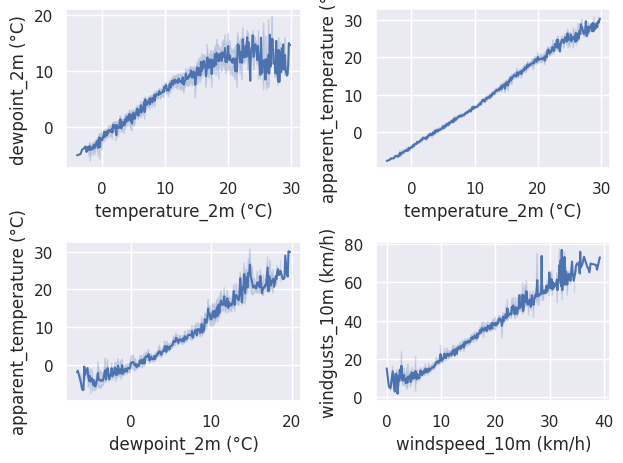

In [213]:
sns.set_theme()
fig, axes = plt.subplots(2, 2)
sns.lineplot(data=dfwheater, x='temperature_2m (°C)', y='dewpoint_2m (°C)', ax=axes[0,0])
sns.lineplot(data=dfwheater, x='temperature_2m (°C)', y='apparent_temperature (°C)', ax=axes[0,1])
sns.lineplot(data=dfwheater, x='dewpoint_2m (°C)', y='apparent_temperature (°C)', ax=axes[1,0])
sns.lineplot(data=dfwheater, x='windspeed_10m (km/h)', y='windgusts_10m (km/h)', ax=axes[1,1])
plt.tight_layout()
plt.show()

A significant correlation exists and an almost linear relationship between Temperature (2m), Dewpoint (2m), and Apparent Temperature, with a correlation coefficient exceeding 80%. Similarly, a substantial correlation is observed between Wind Speed (10m) and Wind Gusts (10m). Considering these observations, it's crucial to retain only one variable from the correlated pairs, specifically Temperature (2m) and Wind Speed (10m).

Furthermore, a correlation is observed among Shortwave Radiation, Temperature (2m), and Is Day or Night, but with a correlation coefficient ranging between 50-60%. Shortwave Radiation will be deleted as a variable.Despite the moderate correlation between Temperature and Is Day or Night, these values will both be retained due to their importance.

# Data Preprocessing

During data exploration, several data points within indices 2279-2591 were identified as containing no bike counts. These points will be removed from both the bike dataset (Y dataset) and weather dataset (X dataset). Additionally, variables exhibiting a high correlation will be eliminated, including Dewpoint (2m), Apparent Temperature, and Wind Gusts (10m). Moreover, the Time column will be dropped as it does not contribute to the training process.

Furthermore, to ensure consistent shapes between datasets, it was discovered that one data point was missing in the bikes dataset at index 2018 (2023-03-26T02). This omission is attributed to the transition from winter to summer time at this particular datapoint. Hence, this specific data point will be removed from the weather dataset, ensuring equal shapes and aligned data for training. Subsequently, both datasets will be split into training and validation sets for model development.

In [214]:
print(dfbikes.shape)
print(dfwheater.shape)

(4343, 2)
(4344, 19)


In [215]:
dfbikes.shape
dfwheater = dfwheater.drop(2018).reset_index(drop=True)
dfwheater['Totaal'] = dfbikes['Totaal']
dffinal = dfwheater.drop(dfwheater.index[2279:2591]).reset_index(drop=True)
dffinal = dffinal.drop(columns=['dewpoint_2m (°C)', 'apparent_temperature (°C)',
                                'windgusts_10m (km/h)', 'time',
                                'shortwave_radiation (W/m²)'
                                ])

In [216]:
print(f'The dimensions of the final dataset are: {dffinal.shape}')
dffinal.head()

The dimensions of the final dataset are: (4031, 15)


,temperature_2m (°C),precipitation (mm),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),winddirection_10m (°),is_day (),timestamp,month,day_of_week,hour,is_weekend,ugent_holiday,is_holiday,Totaal
0,15.9,0.0,1006.2,44,38.7,218,0,2023-01-01 00:00:00,1,6,0,1,1,1,111.0
1,15.8,0.0,1006.7,78,37.3,220,0,2023-01-01 01:00:00,1,6,1,1,1,1,201.0
2,15.8,0.0,1006.7,86,36.9,218,0,2023-01-01 02:00:00,1,6,2,1,1,1,170.0
3,15.3,0.0,1006.4,80,37.0,217,0,2023-01-01 03:00:00,1,6,3,1,1,1,144.0
4,14.7,0.0,1007.3,70,35.5,220,0,2023-01-01 04:00:00,1,6,4,1,1,1,155.0



StandardScaler is employed on the non-categorical variables, despite HistGradientBoostingRegressor's general robustness to non-scaled data, in anticipation of the forthcoming use of L2 regularization.

HistGradientBoostingRegressor is inherently robust to non-scaled data due to its underlying histogram-based approach. Unlike traditional gradient boosting methods that split data based on individual feature values, HistGradientBoostingRegressor builds histograms for each feature, grouping contiguous values into bins. This allows the algorithm to effectively handle features with different scales without the need for explicit scaling.

However L2 regularization can be sensitive to feature magnitudes, and StandardScaler ensures that all features share a comparable scale. This preprocessing step promotes stable convergence and prevents larger-magnitude features from dominating the regularization term, enhancing the model's ability to discern patterns and preventing unwanted influence from specific features.

In [217]:
non_categorical_columns = dffinal.select_dtypes(exclude=['category']).columns
non_categorical_columns = non_categorical_columns.drop(['timestamp', 'Totaal'])
scaler = StandardScaler()
dffinal_scaled = dffinal.copy()
dffinal_scaled[non_categorical_columns] = scaler.fit_transform(dffinal[non_categorical_columns])
dffinal_scaled.head()

,temperature_2m (°C),precipitation (mm),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),winddirection_10m (°),is_day (),timestamp,month,day_of_week,hour,is_weekend,ugent_holiday,is_holiday,Totaal
0,0.883367,-0.286467,-0.933807,-0.299989,3.715393,0.453295,0,2023-01-01 00:00:00,1,6,0,1,1,1,111.0
1,0.867975,-0.286467,-0.887979,0.586830,3.501782,0.472244,0,2023-01-01 01:00:00,1,6,1,1,1,1,201.0
2,0.867975,-0.286467,-0.887979,0.795493,3.440751,0.453295,0,2023-01-01 02:00:00,1,6,2,1,1,1,170.0
3,0.791016,-0.286467,-0.915476,0.638996,3.456009,0.443821,0,2023-01-01 03:00:00,1,6,3,1,1,1,144.0
4,0.698665,-0.286467,-0.832986,0.378167,3.227140,0.472244,0,2023-01-01 04:00:00,1,6,4,1,1,1,155.0


Given the abnormal nature of July, characterized by a lower number of cyclists due to a reduced student population, the validation set is thoughtfully curated instead of being randomly selected. Thirty days will be chosen, comprising 15 holidays and 15 regular days. This approach aims to provide a more accurate representation of July, enhancing the model's predictive capabilities. The selected days will be key in tuning the model's hyperparameters. Following the split, the timestamp column will be removed for further analysis.

In [218]:
holiday15 = random.sample(all_holidays, 15)
normal15 = []
for _ in range(15):
    random_day = date(2023, 1, 1) + timedelta(days=random.randint(0, (date(2023, 6, 30) - date(2023, 1, 1)).days))
    normal15.append(random_day)
validation30 = holiday15 + normal15
dffinal_scaled['timestamp'] = dffinal_scaled['timestamp'].dt.date
validationset = dffinal_scaled[dffinal_scaled['timestamp'].isin(validation30)]
validationset = validationset.drop(columns='timestamp')
trainingset = dffinal_scaled.drop(validationset.index)

In [219]:
X_train = trainingset.drop(columns=['Totaal','timestamp'])
y_train = trainingset['Totaal']
X_val = validationset.drop(columns=['Totaal'])
y_val = validationset['Totaal']

In [220]:
# Making sure the shapes are the same for train and val
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(3575, 13) (3575,) (456, 13) (456,)


# Model training and validation

HistGradientBoostingRegressor was selected for its efficient handling of large datasets and robustness to outliers. Employing a histogram-based approach, it accelerates training by creating feature histograms, a valuable asset when dealing with extensive data. TGradient boosting algorithms, including HistGradientBoostingRegressor, are renowned as kings of tabular data due to their ability to capture complex relationships in structured datasets consisting of both numerical and categorical variables, making them a powerful choice for this tabular data prediction task on top of its resistance to overfitting.

GridSearchCV was utilized to fine-tune the HistGradientBoostingRegressor model by systematically exploring a range of hyperparameter combinations. The parameter grid encompasses key aspects such as the loss function, maximum iterations, tree depth, learning rate and L2 regularization. In this script, the final, optimized hyperparameters can be seen in the parameter grid.

Loss Function ("loss"): I opted for "poisson" since our task involves predicting counts of bicyclists in a poisson distribution. The Poisson loss is well-suited for count data, aligning with the inherent nature of our prediction.

Maximum Iterations ("max_iter"): Setting it at 900 was a result of finding a balance. Too few iterations might oversimplify the model, while too many could lead to overfitting. It's about striking the right balance between complexity and training efficiency.

Maximum Depth of Estimators ("max_depth"): With a max depth of 28, I aimed to let each decision tree capture intricate patterns in the data. This is crucial for tabular data, where relationships can be complex.

Learning Rate ("learning_rate"): I settled on 0.015 through experimentation. A smaller learning rate prevents overshooting but demands more iterations. It's about finding that sweet spot between accuracy and computational efficiency.

L2 Regularization ("l2_regularization"): A value of 0.5 was chosen for a balanced regularization effect. It helps prevent overfitting by penalizing large coefficients.

These choices are a product of a hands-on, trial-and-error approach, considering the intricacies of our dataset and the nuances of the bicyclist count prediction task. They reflect a tailored strategy to achieve the best possible model performance on the validation set.

Categorical features had to be explicitly indicated in the HistGradientBoostingRegressor model.

Sample weights are incorporated, assigning a higher weight (1.5) to instances corresponding to holidays. This is done to enhance sensitivity and ensure that the remaining holidays in the training set receive sufficient emphasis during model training.

The grid search employs RepeatedKFold cross-validation with 5 splits and 2 repeats, ensuring thorough model evaluation. This technique involves repeating the k-fold cross-validation process multiple times, which serves to mitigate variability in the evaluation metrics. By subjecting the model to different data subsets, it helps address potential biases and provides a more stable estimate of its generalization performance. The repetition not only offers a clearer understanding of how consistently the model performs across diverse data splits but also ensures a comprehensive assessment under various conditions.

R2 scores are printed for both training and validation set to give better insight in the model performance.

In [285]:
categories = ['is_day ()', 'hour', 'is_weekend', 'ugent_holiday', 'is_holiday', 'month', 'day_of_week']
model = HistGradientBoostingRegressor()
parameter_grid = {
    "loss" :['poisson'],
    "max_iter": [900],
    "max_depth": [28],
    "learning_rate": [0.015],
    "l2_regularization": [0.5],
    "categorical_features":[categories]
    }

sample_weights = []
is_ugent_holiday = X_train['ugent_holiday'] == 1
is_normal_holiday = X_train['is_holiday'] == 1
is_oneof_holiday = np.logical_or(is_ugent_holiday, is_normal_holiday)
sample_weights = [1.5 if holiday else 1.0 for holiday in is_oneof_holiday]

cv = RepeatedKFold(n_splits=5, n_repeats=2)
clf = GridSearchCV(model, parameter_grid, n_jobs=-1, cv=cv)
clf.fit(X_train, y_train, sample_weight=sample_weights)

r2_train = clf.score(X_train, y_train)
r2_val = clf.score(X_val, y_val)

print("Best hyperparameters: " + str(clf.best_params_))
print('R2 score tuned random forest on training set: ' + str(r2_train))
print('R2 score tuned random forest on valdiation set: ' + str(r2_val))

Best hyperparameters: {'categorical_features': ['is_day ()', 'hour', 'is_weekend', 'ugent_holiday', 'is_holiday', 'month', 'day_of_week'], 'l2_regularization': 0.5, 'learning_rate': 0.015, 'loss': 'poisson', 'max_depth': 28, 'max_iter': 900}
R2 score tuned random forest on training set: 0.985917754195065
R2 score tuned random forest on valdiation set: 0.8608933499456382


This plot serves as a tool for evaluating the model's performance by visually comparing the predicted and actual values. The blue line represents the observed number of cyclists, while the red dashed line indicates the model's predictions. This side-by-side comparison allows for quick pattern recognition, aiding in understanding how well the model captures the underlying trends in the data.

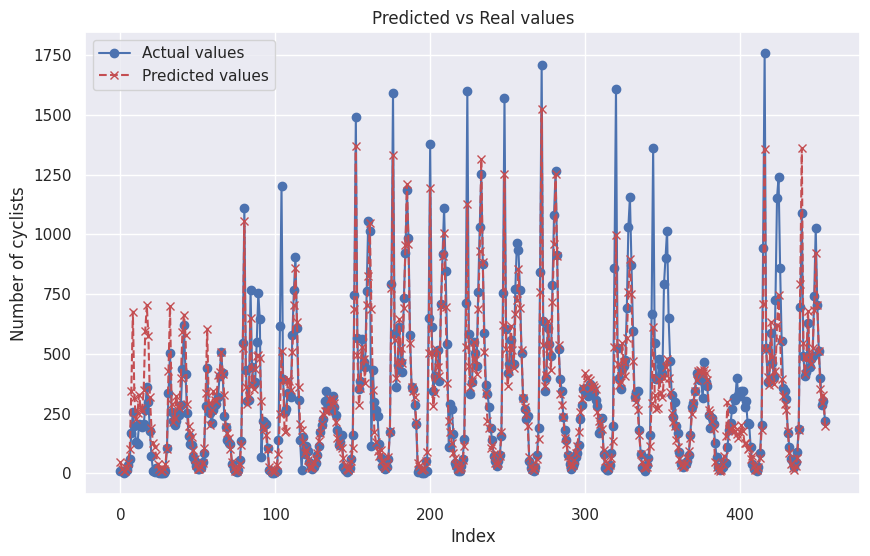

In [286]:
y_val_pred = clf.best_estimator_.predict(X_val)
plt.figure(figsize=(10, 6))
plt.plot(y_val.reset_index()['Totaal'], label='Actual values', marker='o', linestyle='-', color='b')
plt.plot(y_val_pred, label='Predicted values', marker='x', linestyle='--', color='r')
plt.xlabel('Index')
plt.ylabel('Number of cyclists')
plt.title('Predicted vs Real values')
plt.legend()
plt.grid(True)
plt.show()

# Outputting test results

In the project's concluding phase, test results are generated following the established guidelines for predicting bike counts in July. Similar processing steps are applied to the test set as were executed for the training and validation sets, including the addition of relevant variables and scaling. The ultimate outcome is a CSV file designed for upload to Kaggle, where July predictions undergo scoring. Scores within a range were observed, typically falling between 75-80% when employing HistGradientBoosting, with variations influenced by chosen hyperparameters.

In [287]:
datasettest = pd.read_csv('test_data.csv')
dfwheatertest = pd.read_csv('Wheater test.csv', skiprows=3)
dfwheatertest['timestamp'] = pd.to_datetime(dfwheatertest['time'])
dfwheatertest['month'] = dfwheatertest['timestamp'].dt.month.astype("category")
dfwheatertest['day_of_week'] = dfwheatertest['timestamp'].dt.dayofweek.astype("category")
dfwheatertest['hour'] = dfwheatertest['timestamp'].dt.hour.astype("category")
dfwheatertest['is_weekend'] = dfwheatertest['day_of_week'].isin([5, 6]).astype(int).astype("category")
dfwheatertest['ugent_holiday'] = dfwheatertest['timestamp'].apply(lambda x: 1 if x.date() in ugent_holidays else 0).astype("category")
dfwheatertest['is_holiday'] = dfwheatertest['timestamp'].apply(lambda x: 1 if x.date() in holiday else 0).astype("category")
dffinaltest = dfwheatertest.drop(columns=['dewpoint_2m (°C)', 'apparent_temperature (°C)',
                                'windgusts_10m (km/h)', 'time', 'timestamp',
                                'shortwave_radiation (W/m²)'
                                ])
dffinaltest.head()

,temperature_2m (°C),precipitation (mm),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),winddirection_10m (°),is_day (),month,day_of_week,hour,is_weekend,ugent_holiday,is_holiday
0,17.9,0.0,1008.2,84,14.0,209,0,7,5,0,1,1,0
1,17.9,0.0,1007.7,100,16.3,208,0,7,5,1,1,1,0
2,18.0,0.0,1007.0,100,18.8,206,0,7,5,2,1,1,0
3,17.7,0.0,1006.3,100,20.4,206,0,7,5,3,1,1,0
4,17.4,0.0,1005.4,100,21.9,207,0,7,5,4,1,1,0


In [288]:
non_categorical_columns = dffinaltest.select_dtypes(exclude=['category']).columns
scaler = StandardScaler()
dffinaltest_scaled = dffinaltest.copy()
dffinaltest_scaled[non_categorical_columns] = scaler.fit_transform(dffinaltest[non_categorical_columns])
dffinaltest_scaled.head()

,temperature_2m (°C),precipitation (mm),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),winddirection_10m (°),is_day (),month,day_of_week,hour,is_weekend,ugent_holiday,is_holiday
0,-0.218676,-0.288918,-0.553228,0.852287,-0.138491,-0.289870,-1.418501,7,5,0,1,1,0
1,-0.218676,-0.288918,-0.658448,1.333487,0.219602,-0.307036,-1.418501,7,5,1,1,1,0
2,-0.186999,-0.288918,-0.805757,1.333487,0.608834,-0.341369,-1.418501,7,5,2,1,1,0
3,-0.282031,-0.288918,-0.953065,1.333487,0.857942,-0.341369,-1.418501,7,5,3,1,1,0
4,-0.377063,-0.288918,-1.142462,1.333487,1.091481,-0.324203,-1.418501,7,5,4,1,1,0


In [289]:
y_test_pred = clf.best_estimator_.predict(dffinaltest)
testdf = pd.DataFrame(y_test_pred)
testdf = pd.DataFrame([datasettest['Id'], y_test_pred]).T
testdf.columns = ["Id", "Predicted"]
testdf.to_csv("HGBRsubmission.csv", index=False)

# Conclusion

Throughout this project, I gained valuable insights into the intricacies of machine learning workflows. Starting with data exploration, I delved into descriptive statistics and visualizations to identify patterns, outliers, and trends in the dataset. The importance of feature selection and preprocessing became evident as I handled missing values, encoded categorical variables, and considered temporal aspects. As well as becoming evident when trying to increase the predictive power of the model used. The application of a Histogram Gradient Boosting regressor for predicting bicyclist counts provided a hands-on experience with an efficient model for tabular data. Utilizing GridsearchCV for cross-validation deepened my understanding of model evaluation and performance assessment. Furthermore, I learned the significance of careful data curation, especially when dealing with anomalies and outliers as well as dealing with predicting an abnormal month of July, which presented challenges due to limited alike datapoints.

This project not only improved my technical skills in machine learning but also emphasized the importance of good practices in data science, from exploration to validation and final output and I can say that I am happy with the prediction score I was able to reach on Kaggle, especially given the rough start I had in the beginning. This project was largely characterized by a trial-and-error approach, however also contributing to a deeper understanding of the techniques in this final script.